# Machine Learning Challenge

Étudiants :
- MONNIER Raphaël
- PLANCHENAULT Allan
- POINGT Tanguy
- TAROT Bastien

Technique de Machine Learning utilisée pour construire le modèle : Se baser sur les images pour construire un modèle CNN

## Installation des libraries

In [1]:
%pip install numpy matplotlib pandas scikit-learn keras tensorflow torch torchvision

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Code réutilisable

### Variables globales

In [2]:
emotion_to_number = {
    "neutral": 0,
    "happy": 1,
    "sad": 2,
    "anger": 3,
    "surprise": 4,
    "disgust": 5,
    "fear": 6
}

number_to_emotion = {
    0 : "neutral",
    1 : "happy",
    2 : "sad",
    3 : "anger",
    4 : "surprise",
    5 : "disgust",
    6 : "fear"
}

BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 20

### Classes

In [3]:
# Define the EmotionDataset class based on the Dataset class from PyTorch
class EmotionDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file, usecols=[0, 1])
        self.landmarks = pd.read_csv(annotations_file, usecols=lambda col: col not in ['id', 'labels'])
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")

        # Extract landmarks
        landmarks = self.landmarks.iloc[idx, :].values
        x = landmarks[:68]
        y = landmarks[68:]

        # Bounding box
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()

        # Crop the image
        image = image.crop((x_min, y_min, x_max, y_max))

        label = self.img_labels.iloc[idx, 1]
        label = emotion_to_number[label]

        if self.transform:
            image = self.transform(image)

        return image, label

## Préparation des données

Mean: tensor([0.6097, 0.4512, 0.4468])
Std: tensor([0.1499, 0.1336, 0.1338])


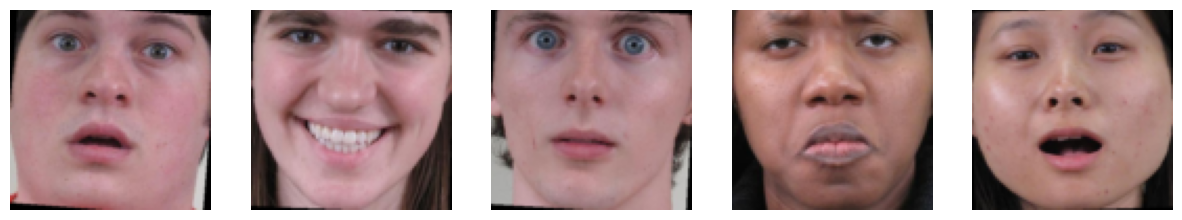

In [4]:
# Define a temporary transform without normalization
temp_transform = transforms.Compose([
    transforms.Resize((1000, 750)),
    transforms.ToTensor()
])

# Load the dataset with the temporary transform
img_dir = "./project_data/training_set/"
csv_file = "./project_data/training_set.csv"

temp_dataset = EmotionDataset(annotations_file=csv_file, img_dir=img_dir, transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize variables to calculate mean and std
mean = 0.0
std = 0.0
nb_samples = 0

# Iterate through the dataset to calculate mean and std
for data in temp_loader:
    images, _ = data
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'Mean: {mean}')
print(f'Std: {std}')

# Define the final transform with normalization
transform = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

# Load the final dataset with the normalization transform
dataset = EmotionDataset(annotations_file=csv_file, img_dir=img_dir, transform=transform)

# Split the dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Function to denormalize and convert tensor to PIL image
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Visualize some images after transformations
def show_images(loader, mean, std, num_images=5):
    data_iter = iter(loader)
    images, _ = next(data_iter)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = denormalize(images[i], mean, std)
        img = transforms.ToPILImage()(img)
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# Show some images from the training loader
show_images(train_loader, mean.tolist(), std.tolist(), num_images=5)

In [5]:
class CNNEmotionClassifier(nn.Module):
    def __init__(self):
        super(CNNEmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, 7)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.35)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 12 * 12)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = CNNEmotionClassifier()

Epoch [1/20], Training Loss: 1.9592, Training Accuracy: 17.86%, Validation Accuracy: 21.92%
Epoch [2/20], Training Loss: 1.2916, Training Accuracy: 51.24%, Validation Accuracy: 56.85%
Epoch [3/20], Training Loss: 0.9085, Training Accuracy: 63.98%, Validation Accuracy: 71.92%
Epoch [4/20], Training Loss: 0.7116, Training Accuracy: 72.33%, Validation Accuracy: 74.66%
Epoch [5/20], Training Loss: 0.6199, Training Accuracy: 75.40%, Validation Accuracy: 71.92%
Epoch [6/20], Training Loss: 0.5540, Training Accuracy: 80.23%, Validation Accuracy: 67.81%
Epoch [7/20], Training Loss: 0.5777, Training Accuracy: 76.13%, Validation Accuracy: 78.77%
Epoch [8/20], Training Loss: 0.4516, Training Accuracy: 82.43%, Validation Accuracy: 70.55%
Epoch [9/20], Training Loss: 0.4080, Training Accuracy: 84.33%, Validation Accuracy: 76.03%
Epoch [10/20], Training Loss: 0.3861, Training Accuracy: 85.07%, Validation Accuracy: 73.97%
Epoch [11/20], Training Loss: 0.3480, Training Accuracy: 87.26%, Validation Acc

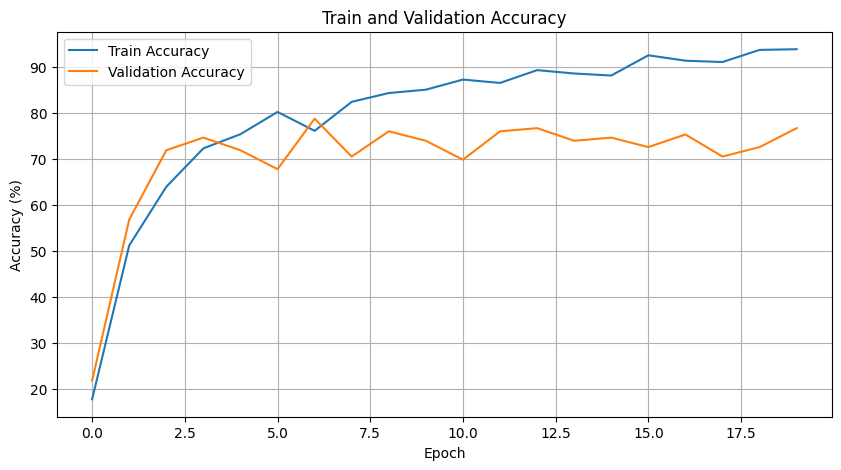

Finished Training


In [53]:
# Initialize lists to store the accuracy per epoch
train_acc_history = []
val_acc_history = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    # Train phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_acc_history.append(train_accuracy)  # Store train accuracy

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_acc_history.append(val_accuracy)  # Store validation accuracy

    print(f'Epoch [{epoch+1}/{EPOCHS}], Training Loss: {running_loss/len(train_loader):.4f}, '
          f'Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

# Plotting Training and Validation Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print('Finished Training')

In [54]:
# Test phase
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f'Accuracy of the model on the test set: {test_accuracy:.2f}%')

Accuracy of the model on the test set: 74.32%


In [55]:
model_save_path = "./cnn_model.pth"
torch.save(model.state_dict(), model_save_path)

## Test du modèle (dans le cadre du rendu intermédiaire et final du challenge)

### Chargement des données de test

In [8]:
test_csv_path = "./test_final/test_data.csv"
test_image_path = "./test_final/testing_set/"

# Load the torch model
model = torch.load("cnn_model.pth")

C:\Users\basti\AppData\Local\Temp\ipykernel_1760\1083658745.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("cnn_model.pth")


### Classe personnalisée pour le dataset de test comme on a pas les labels

In [9]:
# Create a TestDataset espacially for the testing data (no labels)
class TestDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_ids = pd.read_csv(annotations_file, usecols=[0])
        self.landmarks = pd.read_csv(annotations_file, usecols=lambda col: col not in ['id'])
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_ids.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")

        # Extract landmarks
        landmarks = self.landmarks.iloc[idx, :].values
        x = landmarks[:68]
        y = landmarks[68:]

        # Bounding box
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()

        # Crop the image
        image = image.crop((x_min, y_min, x_max, y_max))

        if self.transform:
            image = self.transform(image)

        return image

### Préparation des données de tests (normalisation, etc.)

Mean: tensor([0.6102, 0.4517, 0.4472])
Std: tensor([0.1497, 0.1337, 0.1337])


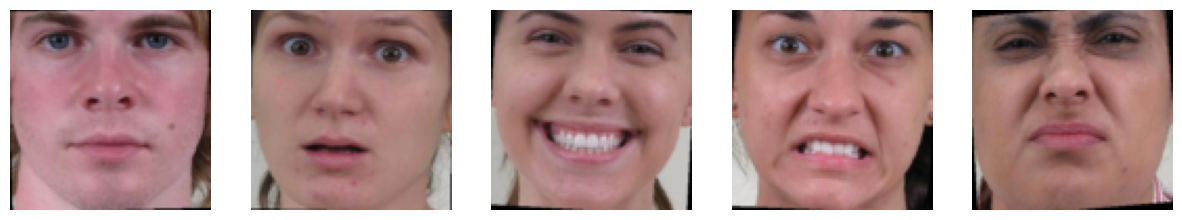

In [10]:
temp_dataset = TestDataset(annotations_file=test_csv_path, img_dir=test_image_path, transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize variables to calculate mean and std
mean = 0.0
std = 0.0
nb_samples = 0

# Iterate through the dataset to calculate mean and std
for data in temp_loader:
    images = data
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'Mean: {mean}')
print(f'Std: {std}')

# Define the final transform with normalization
transform = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

# Load the final dataset with the normalization transform
dataset = TestDataset(annotations_file=test_csv_path, img_dir=test_image_path, transform=transform)
test_loader_ = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

# Function to denormalize and convert tensor to PIL image
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Visualize some images after transformations
def show_images(loader, mean, std, num_images=5):
    data_iter = iter(loader)
    images = next(data_iter)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img = denormalize(images[i], mean, std)
        img = transforms.ToPILImage()(img)
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# Show some images from the test loader
show_images(test_loader_, mean.tolist(), std.tolist(), num_images=5)

### Prédiction sur les données de test

In [11]:
# Test phase
model = CNNEmotionClassifier()
model.load_state_dict(torch.load("cnn_model.pth"))
model.eval()

results = []

with torch.no_grad():
    for images in test_loader_:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for pred in predicted:
            results.append(number_to_emotion[pred.item()])
df = pd.DataFrame(results, columns=['labels'])
df.to_csv('result_final.csv', index=False)

C:\Users\basti\AppData\Local\Temp\ipykernel_1760\384614003.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_model.pth"))


In [13]:
# Compare res.csv and results.csv on column labels
res = pd.read_csv('./test_final/test_final_pseudo_labels.csv')
results = pd.read_csv('result_final.csv')

# Measure accuracy
accuracy = np.sum(res['labels'] == results['labels']) / len(res['labels'])
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 69.45%
